In [1]:
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# https://www.youtube.com/watch?v=QIUxPv5PJOY

def format_data(df,start, end):
    training_data = df[start:end].drop('Date', axis = 1)
    return(training_data)
        
def create_xy_scaled(df, samples):
    
    dataset = df.values
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(dataset)
    data = scaled_data
    x = []
    y = []

    for i in range(samples, len(df)):
        x.append(data[i-samples:i])
        y.append(data[i])
        
    return(np.array(x), np.array(y), scaler)



In [4]:
df = pd.read_csv('dataset_QQQ_8_20140207_to_20181231.csv')
df.drop('Date', axis =1, inplace = True)
#df.drop('RSI_Correlation', axis = 1, inplace = True)
samples = 100


x = create_xy_scaled(df,samples)[0]
y = create_xy_scaled(df, samples)[1]
scale = create_xy_scaled(df,samples)[2]
x_train = x[:1000].copy()
y_train = y[:1000].copy()

x_test = x[1001:].copy()
y_test = y[1001:].copy()

(1000, 100, 8)

In [12]:
hyparam ={'loss':'mean_squared_error',
         'opt':'Adam',
         'epochs': 20,
         'batch_size':8}

regressor = Sequential()

regressor.add(LSTM(units = 16, activation = 'relu', return_sequences = True, input_shape = (x_train.shape[1], x_train.shape[2])))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 16, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 32, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 64, activation = 'relu',))
regressor.add(Dropout(0.4))

regressor.add(Dense(units=y_train.shape[1]))

regressor.compile(optimizer = hyparam['opt'], loss = hyparam['loss'])

regressor.fit(x_train, y_train, epochs = hyparam['epochs'], batch_size = hyparam['batch_size'])

Train on 1000 samples
Epoch 1/20
1000/1000 [==============================] - 23s 23ms/sample - loss: 7.9622
Epoch 2/20
1000/1000 [==============================] - 18s 18ms/sample - loss: 0.0427
Epoch 3/20
1000/1000 [==============================] - 18s 18ms/sample - loss: 0.0316
Epoch 4/20
1000/1000 [==============================] - 19s 19ms/sample - loss: 0.0257
Epoch 5/20
1000/1000 [==============================] - 19s 19ms/sample - loss: 0.0218
Epoch 6/20
1000/1000 [==============================] - 18s 18ms/sample - loss: 0.0196
Epoch 7/20
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.0176
Epoch 8/20
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.0164
Epoch 9/20
1000/1000 [==============================] - 19s 19ms/sample - loss: 0.0159
Epoch 10/20
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.0151
Epoch 11/20
1000/1000 [==============================] - 17s 17ms/sample - loss: 0.0148
Epoch 12/20
1000/10

In [13]:
regressor.save('2020-06-28-2-regressor.model')

W0628 18:17:26.912265  9952 deprecation.py:506] From c:\users\olfoa\appdata\local\programs\python\python36\lib\site-packages\tensorflow_core\python\ops\resource_variable_ops.py:1781: calling BaseResourceVariable.__init__ (from tensorflow.python.ops.resource_variable_ops) with constraint is deprecated and will be removed in a future version.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [1]:
import datetime as dt
from datetime import date
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import time
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
%matplotlib inline
        
def create_xy_scaled(df, samples):
    
    dataset = df.values
    scaler = MinMaxScaler(feature_range = (0,1))
    scaled_data = scaler.fit_transform(dataset)
    data = scaled_data
    x = []
    y = []

    for i in range(samples, len(df)):
        x.append(data[i-samples:i])
        y.append(data[i])
        
    return(np.array(x), np.array(y), scaler)

#returns list of RSI values over n periods
def RSI(df, n):
    L = len(df)
    up = [0]*L
    down = [0]*L
    
    for i in range(1,L):
        if df['Close'][i-1] <= df['Close'][i]:
            up[i] = df['Close'][i] - df['Close'][i-1]
        if df['Close'][i-1] > df['Close'][i]:
            down[i] = abs(df['Close'][i] - df['Close'][i-1])

    avg_up= [0]*L
    avg_down = [0]*L
    
    avg_up[n] = np.mean(up[1:n+1])
    avg_down[n] = np.mean(down[1:n+1])
    
    for i in range(n+1,L):
        avg_up[i] = (avg_up[i-1]*(n-1)+up[i])/n
        avg_down[i] = (avg_down[i-1]*(n-1)+down[i])/n
    
    #return(avg_up,avg_down)
    RSI = [0]*L
    for i in range(n,L):
        RSI[i]= 100 - 100/(1+ (avg_up[i-1]/avg_down[i]))
    
    return(RSI)

#EMA, returns list of exponential moving average over n periods
def SMA(stock_df,n):
    A = [0]*len(stock_df)
    for i in range(len(stock_df)-n+1):
        A[i+n-1] = np.mean(list(stock_df['Close'][i:i+n]))
    return(A)

def EMA(stock_df,n):
    mult = 2/(n+1)
    A = [0]*len(stock_df)
    A[n-1] = SMA(stock_df,n)[n-1]
    for i in range(n-1,len(stock_df)-1):
        A[i-1] = A[i]+(stock_df['Close'][i]-A[i])*mult
    return(A)

def close_price(stock_df):
    A = [0]*len(stock_df)
    for i in range(len(stock_df)-1):
        A[i+1] = stock_df['Close'][i]*(1+stock_df['pct change'][i])
    return(A)

def bol_bands(stock_df, n):
    L = len(stock_df)
    price = list(stock_df['Close'])
    std_dev = list(stock_df['Close'].rolling(window = n).std())
    mean = list(stock_df['Close'].rolling(window = n).mean())
    upper_band = [0]*L
    lower_band = [0]*L
    
    for i in range(L):
        upper_band[i] = mean[i] + 2*std_dev[i]
        lower_band[i] = mean[i] - 2*std_dev[i]
    
    return(upper_band, lower_band)

def RSI_div(stock_df):
    L = len(stock_df)
    RSI_div = [0]*L
    for i in range(L):
        RSI_div[i] = (stock_df['Close'][i]-stock_df['RSI'][i])/(stock_df['Close'][i]+stock_df['RSI'][i])
    
    return RSI_div

def unscale(data, scaler):
    return(scaler.inverse_transform(data))

def rescale(data, scaler):
    return(scaler.transform(data))

def pred(x, model):
    return(model.predict(x))

def pred(x, model):
    x = x.reshape(1, x.shape[0], x.shape[1])
    return(model.predict(x))

def make_new_row(df_columns, values):
    new_row = {}
    for i in range(len(values)):
        new_row[df_columns[i]] = values[i]
    return(new_row)

## execution text



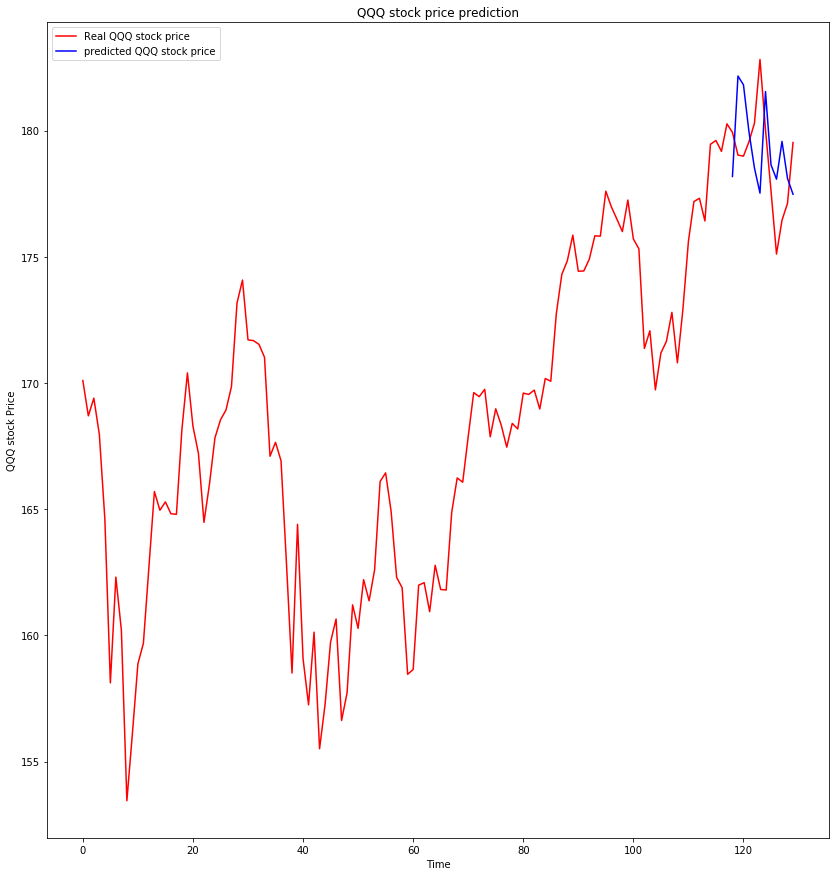

In [2]:
model = tf.keras.models.load_model('2020-06-28-2-regressor.model')
QQQ = pd.read_csv('dataset_QQQ_8_20140207_to_20181231.csv')

QQQ.drop('Date', axis =1, inplace = True)

samples = 100
scale = create_xy_scaled(QQQ,samples)[2]

forecast = 10
start = 1000
end = start + 120
df = QQQ[start:end].reset_index(drop=True).copy()
df_test = QQQ[start:end+forecast].reset_index(drop = True).copy()

for i in range(forecast):
    input = rescale(df[-samples:], scale)
    new_row_values = unscale(pred(input[-samples:], model), scale)
    df = df.append(make_new_row(df.columns, new_row_values[0]), ignore_index = True)
    #df['RSI'] = RSI(df, 9)
    df['12 EMA'] = EMA(df, 12)
    df['26 EMA'] = EMA(df, 26)
    df['Close'] = close_price(df)
    df['RSI div'] = RSI_div(df) 
    #df['bol band upper'] = bol_bands(df,20)[0]
    #df['bol band lower'] = bol_bands(df,20)[1]

df_out = df[-(forecast+2):].copy()

actual = df_test['Close']
pred = df_out['Close']

plt.figure(figsize = (14,15))
plt.plot(actual, color = 'red', label = 'Real QQQ stock price')
plt.plot(pred, color = 'blue', label = 'predicted QQQ stock price')
plt.title('QQQ stock price prediction')
plt.xlabel('Time')
plt.ylabel('QQQ stock Price')
plt.legend()
plt.show()

#df['RSI'] cuasing divide by zero


,Close,RSI,12 EMA,26 EMA,pct change,RSI div,bol band upper,bol band lower
130,166.269119,65.932536,25.843636,12.443232,0.010899,0.432110,168.218747,157.922258
131,171.414333,70.686182,25.910243,12.475302,0.010364,0.416059,169.340262,157.541742
132,169.724696,73.641962,26.368832,12.696104,-0.000943,0.394806,170.235840,157.455165
133,168.257724,73.641962,25.961370,12.499919,0.001711,0.391136,171.081323,157.324681
134,171.690719,63.408165,25.822960,12.433277,-0.011075,0.460583,171.316573,157.266430
135,166.879986,63.408165,26.490188,12.754535,0.006612,0.449315,171.694469,157.142534
136,168.959106,63.357743,26.112117,12.572501,-0.003847,0.454557,172.071930,157.107072
137,171.523894,58.527367,25.736732,12.391760,-0.005168,0.491180,172.353341,157.341662
138,168.851539,58.527367,26.190059,12.610029,0.005613,0.485200,172.703404,157.642598
139,168.227787,61.092893,26.142014,12.586896,-0.001306,0.467184,172.596495,158.721506


,Close,RSI,12 EMA,26 EMA,pct change,RSI div,bol band upper,bol band lower
130,167.880005,65.932536,163.338665,162.843296,0.010899,0.436022,168.218747,157.922258
131,169.619995,70.686182,164.037333,163.216386,0.010364,0.411699,169.340262,157.541742
132,169.460007,73.641962,164.896204,163.690727,-0.000943,0.394148,170.235840,157.455165
133,169.750000,73.641962,165.598327,164.118081,0.001711,0.394869,171.081323,157.324681
134,167.869995,63.408165,166.237046,164.535260,-0.011075,0.451672,171.316573,157.266430
135,168.979996,63.408165,166.488269,164.782278,0.006612,0.454291,171.694469,157.142534
136,168.330002,63.357743,166.871612,165.093220,-0.003847,0.453076,172.071930,157.107072
137,167.460007,58.527367,167.095979,165.332981,-0.005168,0.482030,172.353341,157.341662
138,168.399994,58.527367,167.151984,165.490539,0.005613,0.484175,172.703404,157.642598
139,168.179993,61.092893,167.343985,165.706054,-0.001306,0.467073,172.596495,158.721506
